<a href="https://colab.research.google.com/github/KhondamirRustamov/FoldCraft/blob/main/FoldCraft_VHH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FoldCraft - VHH**

This is **FoldCraft** version for *de novo* VHH design

In [1]:
#@title setup
%%time
import os

if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

os.system('pip -q install mdanalysis')
os.system('git clone https://github.com/KhondamirRustamov/Poly-P-in-silico')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

CPU times: user 1.59 s, sys: 261 ms, total: 1.85 s
Wall time: 2min 25s


Target (blue)
VHH (red)


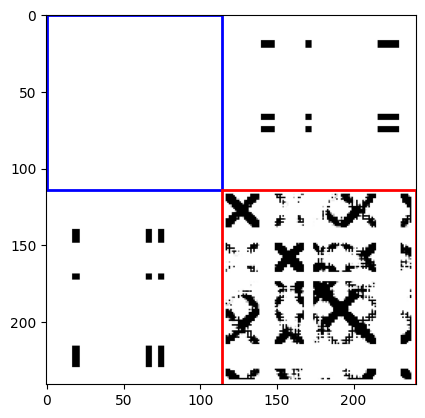

In [6]:
#@title Prepare fold conditioned binder | Construct target cmap for binder-target complex

#plt.imshow(af_model.aux['cmap'])

import matplotlib.pyplot as plt
import MDAnalysis as mda

import warnings

warnings.filterwarnings("ignore")
#@markdown Prepare target protein structure
pdb_target = 'Q9NZQ7' #@param {type:"string"}
#@markdown Select chain for target protein. If you want to **trim** the protein use **":"** after the chain id and write the **start-end** of trimming region using "-"
chain_id = 'A:19-132' #@param {type:"string"}

vhh_framework = np.load('/content/Poly-P-in-silico/vhh.npy')

pdb_target_path = get_pdb(pdb_target)

def set_range(hotspots_input):
  new_h = [x for x in hotspots_input.split(',')]
  h_range = []
  for i in new_h:
    if '-' in i:
      h_range += [x for x in range(int(i.split('-')[0]), int(i.split('-')[1]))]
    else:
      h_range.append(int(i))
  return h_range

#@markdown Choose hotspots on target protein
target_hotspots = '11-17,43-49,34-39' #@param {type:"string"}
#Optional: Choose hotspots on binder protein
binder_hotspots = '26-35,55-59,102-116'

if ':' in chain_id:
  chain_cut = [int(x) for x in chain_id.split(':')[-1].split('-')]
  chain_id = chain_id.split(':')[0]
  uref = mda.Universe(f'AF-{pdb_target}-F1-model_v3.pdb')
  uref = uref.select_atoms(f'resid {chain_cut[0]}:{chain_cut[1]}')
  uref.write(f"AF-{pdb_target}-F1-model_v3.pdb")
  target_hotspots_np = np.array(set_range(target_hotspots))-chain_cut[0]
else:
  target_hotspots_np = np.array(set_range(target_hotspots))

af_target = mk_afdesign_model(protocol="fixbb", use_templates=True)
af_target.prep_inputs(pdb_filename=pdb_target_path,
                     ignore_missing=False,
                     chain = chain_id,)

target_len = af_target._len
binder_len = 127

load_np = vhh_framework

fc_cmap = np.zeros((target_len+binder_len, target_len+binder_len))

if binder_hotspots == '':
  cdr_range = np.array([range(0,binder_len)])+target_len
else:
  cdr_range = np.array(set_range(binder_hotspots))+target_len

fc_cmap[-binder_len:,-binder_len:] = load_np


for i in target_hotspots_np:
    for x in cdr_range:
        fc_cmap[x,i] = 1.
        fc_cmap[i,x] = 1.

from matplotlib import patches
fig, ax = plt.subplots()
plt.imshow(fc_cmap,cmap='grey_r')
rect = patches.Rectangle((0, 0), target_len, target_len, linewidth=2, edgecolor='b', facecolor='none')
rect2 = patches.Rectangle((target_len, target_len), binder_len, binder_len, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)
print('Target (blue)')
print('VHH (red)')
np.save('fold_cond_cmap.npy',fc_cmap)

fc_cmap[fc_cmap>0] = 1
np.save('fold_cond_cmap_mask.npy',fc_cmap)

In [7]:
#@title Define fold-conditioned loss and run 3stage design (100,100,20)
from colabdesign.af.loss import get_contact_map
import jax
import jax.numpy as jnp

conditioned_array = np.load('fold_cond_cmap.npy')
conditioned_mask = np.load('fold_cond_cmap_mask.npy')

def cmap_loss_binder(inputs, outputs):
    global conditioned_array
    global conditioned_mask
    global binder_len

    i_cmap = get_contact_map(outputs, inputs["opt"]["i_con"]["cutoff"])
    cmap = get_contact_map(outputs, inputs["opt"]["con"]["cutoff"])
    i_cmap = i_cmap.at[-binder_len:,-binder_len:].set(cmap[-binder_len:,-binder_len:])
    out_cmap_conditioned = i_cmap * conditioned_mask
    cmap_loss_binder = jnp.sqrt(jnp.square(out_cmap_conditioned - conditioned_array).sum(-1).mean())

    return {"cmap_loss_binder":cmap_loss_binder}

name = 'tmp_0' #@param {type:"string"}
rm_aa = 'C' #@param {type:"string"}

af_model_design = mk_afdesign_model(protocol="binder", loss_callback=cmap_loss_binder,
                                     use_templates=True,)

af_model_design.prep_inputs(pdb_filename=pdb_target_path,
                             chain=chain_id, binder_len = binder_len,
                             hotspot=target_hotspots,
                             rm_aa=rm_aa, #fix_pos=fixed_positions,
                             )

af_model_design.opt["weights"]["cmap_loss_binder"] = 1.
af_model_design.opt["weights"].update({"cmap_loss_binder":1.0, "rmsd":0.0, "fape":0.0, "plddt":0.0,
                                        "con":0.0, "i_con":0.0, "i_pae":0.})

af_model_design.design_3stage(100,100,20)

Stage 1: running (logits → soft)
1 models [0] recycles 0 hard 0 soft 0.01 temp 1 loss 3.55 plddt 0.54 ptm 0.48 i_ptm 0.11 cmap_loss_binder 3.55
2 models [0] recycles 0 hard 0 soft 0.02 temp 1 loss 3.54 plddt 0.54 ptm 0.49 i_ptm 0.14 cmap_loss_binder 3.54
3 models [0] recycles 0 hard 0 soft 0.03 temp 1 loss 3.51 plddt 0.53 ptm 0.49 i_ptm 0.13 cmap_loss_binder 3.51
4 models [1] recycles 0 hard 0 soft 0.04 temp 1 loss 3.54 plddt 0.46 ptm 0.47 i_ptm 0.08 cmap_loss_binder 3.54
5 models [1] recycles 0 hard 0 soft 0.05 temp 1 loss 3.59 plddt 0.62 ptm 0.47 i_ptm 0.07 cmap_loss_binder 3.59
6 models [1] recycles 0 hard 0 soft 0.06 temp 1 loss 3.56 plddt 0.65 ptm 0.47 i_ptm 0.07 cmap_loss_binder 3.56
7 models [1] recycles 0 hard 0 soft 0.07 temp 1 loss 3.61 plddt 0.66 ptm 0.47 i_ptm 0.07 cmap_loss_binder 3.61
8 models [0] recycles 0 hard 0 soft 0.08 temp 1 loss 3.51 plddt 0.57 ptm 0.48 i_ptm 0.11 cmap_loss_binder 3.51
9 models [0] recycles 0 hard 0 soft 0.09 temp 1 loss 3.51 plddt 0.54 ptm 0.49 i

In [8]:
#@title Optimize sequences with ProteinMPNN
import pickle
from colabdesign.mpnn import mk_mpnn_model
import pandas as pd

n_samples = 5  #@param {type:"integer"}
remove_aa = 'C'  #@param {type:"string"}
model_name = "v_48_010" #@param {type:"string"}

af_model_design.save_pdb(f"{name}.pdb", get_best=False)

with open(f'{name}.pickle', 'wb') as handle:
  pickle.dump(af_model_design.aux['all'], handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Running ProteinMPNN...')

design_pos = ','.join([f'B{i}' for i in range(1,binder_len)])

mpnn_model = mk_mpnn_model(model_name, backbone_noise=0.0)
mpnn_model.prep_inputs(pdb_filename=f"{name}.pdb", chain='A,B', fix_pos=design_pos, rm_aa = remove_aa, inverse=True)

samples = mpnn_model.sample_parallel(temperature=0.1, batch=n_samples)

print('Predicting sequences with AF2_ptm...')

names = []
sequences = []
plddts = []
ipaes = []
iptms = []
cmap_loss = []

for num, seq in enumerate(samples['seq']):
  af_model_predict = mk_afdesign_model(protocol="binder", loss_callback=cmap_loss_binder,
                                     use_templates=True,)

  af_model_predict.prep_inputs(pdb_filename=pdb_target_path,
                             chain=chain_id, binder_len = binder_len,
                             hotspot=target_hotspots,
                             rm_aa=rm_aa, #fix_pos=fixed_positions,
                             )
  af_model_predict.set_seq(seq[-binder_len:])
  af_model_predict.predict(num_recycles=3, verbose=False, models=["model_1_ptm","model_2_ptm"])
  print(f"predict: {name}_{num} plddt: {af_model_predict.aux['log']['plddt']:.3f}, i_pae: {(af_model_predict.aux['log']['i_pae']):.3f}, i_ptm: {af_model_predict.aux['log']['i_ptm']:.3f}, cmap_loss: {af_model_predict.aux['log']['cmap_loss_binder']:.3f}")
  af_model_predict.save_pdb(f"{name}_{num}.pdb", get_best=False)
  with open(f'{name}_{num}.pickle', 'wb') as handle:
    pickle.dump(af_model_predict.aux['all'], handle, protocol=pickle.HIGHEST_PROTOCOL)
  names.append(f'{name}_{num}')
  sequences.append(seq)
  plddts.append(af_model_predict.aux['log']['plddt'])
  ipaes.append(af_model_predict.aux['log']['i_pae'])
  iptms.append(af_model_predict.aux['log']['i_ptm'])
  cmap_loss.append(af_model_predict.aux['log']['cmap_loss_binder'])

df = pd.DataFrame({'name':names,
                   'sequence':sequences,
                   'plddt':plddts,
                   'ipae':ipaes,
                   'iptm':iptms,
                   'cmap_loss':cmap_loss})
#print(df)

Running ProteinMPNN...
Predicting sequences with AF2_ptm...
predict: tmp_0_0 plddt: 0.840, i_pae: 0.872, i_ptm: 0.107, cmap_loss: 1.869
predict: tmp_0_1 plddt: 0.838, i_pae: 0.882, i_ptm: 0.097, cmap_loss: 1.888
predict: tmp_0_2 plddt: 0.690, i_pae: 0.875, i_ptm: 0.112, cmap_loss: 2.395
predict: tmp_0_3 plddt: 0.800, i_pae: 0.890, i_ptm: 0.096, cmap_loss: 1.996
predict: tmp_0_4 plddt: 0.781, i_pae: 0.913, i_ptm: 0.087, cmap_loss: 1.969


In [9]:
#@title Plot the best design (by cmap loss)
import py3Dmol

df = df.sort_values(by='cmap_loss')

with open(f"{df['name'].tolist()[0]}.pdb", "r") as file:
    pdb_data = file.read()
color = "lDDT"

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(pdb_data, "pdb")

if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
#@title Animate the hallucination process
HTML(af_model_design.animate())